In [1]:
using Pkg
Pkg.instantiate()
using Tables, CSV
using DataFrames
using MultivariateStats
using LinearAlgebra, Plots, DifferentialEquations, Catalyst, StatsBase, Clustering, Random

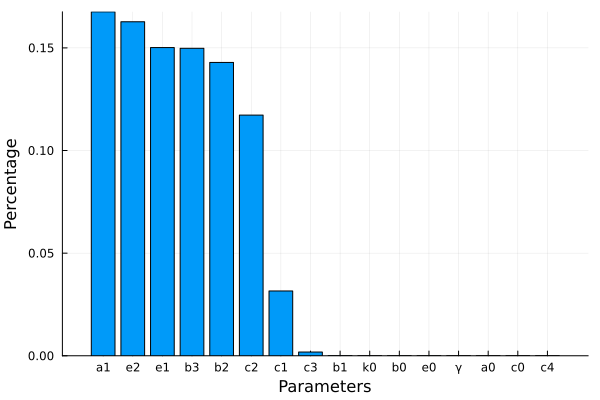

In [2]:
#load posterior distribution obtained from ABC-SMC for MMD
mmd_dens = Matrix(CSV.read("mmd.csv", DataFrame, header = false))
#fitting PCA for MMD
M = fit(PCA, mmd_dens'; maxoutdim=16)
lambda = eigvals(M::PCA)
gamma = eigvecs(M::PCA);
#sensitiy for each parameter up to 7 principle components
sens = zeros(16,7) 
for i in 1:16
    for j in 1:7
      sens[i,j] = gamma[i,j]^2*lambda[j]
    end
end
#sensitivity of each parameter obtained by summing the sensitivity of all principle components 
sensitivity = sum(sens, dims = 2)
names = ["k0","c0","c1","c2","c3","c4","e0" ,"e1", "e2", "a0", "a1" ,"b0", "b1" ,"b2", "b3", "γ"];
sensitivity = vec(sensitivity)
order = sortperm(sensitivity, rev = true)
bar(sensitivity[order], xticks = (1:16, names[order]), label = false, xlabel = "Parameters", ylabel = "Percentage")

In [3]:
savefig("Figure/sensitivity.svg")

"/Users/yujingl3/Desktop/U1/Figure/sensitivity.svg"

In [4]:
mmd_dens = Matrix(CSV.read("mmd.csv", DataFrame, header = false))
opt_dens = Matrix(CSV.read("optimal_transport.csv", DataFrame, header = false))
bhatt_dens = Matrix(CSV.read("bhatta.csv", DataFrame, header = false));
moment_dens = Matrix(CSV.read("moment.csv", DataFrame, header = false))
kmean_dens = Matrix(CSV.read("kmean.csv", DataFrame, header = false));

In [5]:
# stem cell model
# Lif was set to 50
stem_model = @reaction_network begin
     @parameters k0 c0 c1 c2 c3 c4 e0 e1 e2 a0 a1 b0 b1 b2 b3 γ 
    @species N(t) O(t) F(t) G(t)
    (k0*O*(c0 + c1*N^2 + k0*O + c2*50))/(1 + (k0*O*(c1*N^2 + k0*O + c2*50 + c3*F^2)) + c4*O*G^2), ∅ --> N
    (e0 + e1*O)/(1 + e1*O + e2*G^2), ∅ --> O
    (a0 + a1*O)/(1 + a1*O), ∅ --> F
    (b0 + b1*G^2 + b3*O)/(1 + b1*G^2 + b2*N^2 + b3*O), ∅ --> G
    γ, N -->∅
    γ, O -->∅
    γ, F -->∅
    γ, G -->∅
end 
p = [0.005, 0.01, 0.4, 1, 0.1, 0.00135, 0.01, 1, 1, 0.01, 1.0, 0.005, 0.005, 1.0, 1, 0.01] #true parameters
T = 3000.0 #time horizon 
u₀ = [105,110,100,5] # initial states
tspan = (0.0,T) 
dprob = DiscreteProblem(stem_model, u₀, tspan, p)
jprob = JumpProblem(stem_model, dprob, Direct(),save_positions=(false,false))

#generating the data with param as parameters, n is the number of trajectories
function Generating_data(param,n,T)
    timept = 10:div(T, 10):T
    ensprob = EnsembleProblem(jprob,prob_func=(p,i,r)->remake(p,p = param), safetycopy=false)
    
    sol = solve(ensprob, SSAStepper(),EnsembleThreads(), trajectories=n,saveat=1)
    data = hcat(sol[1].u...)[:,timept]
    for i in 2:n
        data = cat(data,hcat(sol[i].u...)[:,timept], dims=3)
    end
    return data
end

Generating_data (generic function with 1 method)

In [6]:
savefig("Figure/Sim_res.png");

In [7]:
function do_kmean(data)
    a = kmeans(data[:,10,:],2)
    ct = 0
    if a.centers[1,1] > a.centers[2,2]
        ct = sum(a.assignments .== 1)/300
    else
        ct = sum(a.assignments .== 2)/300
    end
    return log(ct+10^(-9)/(1-ct)+10^(-9))
end

do_kmean (generic function with 1 method)

In [8]:
p_mmd = zeros(1000)
p_opt = zeros(1000)
p_bhatt = zeros(1000)
p_kmeans = zeros(1000)
p_moment = zeros(1000)
for i = 1:1000
    mmd_p = mmd_dens[i,:]
    dt2 = Generating_data(mmd_p, 300, 3000)
    p_mmd[i] = do_kmean(dt2)
    
    opt_p = opt_dens[i,:]
    dt2 = Generating_data(opt_p, 300, 3000)
    p_opt[i] = do_kmean(dt2)

    bhatt_p = bhatt_dens[i,:]
    dt2 = Generating_data(bhatt_p, 300, 3000)
    p_bhatt[i] = do_kmean(dt2)

    kmean_p = kmean_dens[i,:]
    dt2 = Generating_data(kmean_p, 300, 3000)
    p_kmeans[i] = do_kmean(dt2)

    moment_p = moment_dens[i,:]
    dt2 = Generating_data(moment_p, 300, 3000)
    p_moment[i] = do_kmean(dt2)
    
end

In [9]:
true_mean = zeros(1000)
p = [0.005, 0.01, 0.4, 1, 0.1, 0.00135, 0.01, 1, 1, 0.01, 1.0, 0.005, 0.005, 1.0, 1, 0.01] #true parameters
for i = 1:1000
    dt2 = Generating_data(p, 300, 3000)
    true_mean[i] = do_kmean(dt2)
end
val = mean(true_mean)

-0.2995019653872961

In [10]:
mmd_mse = round(sum((p_mmd .- val).^2)/length(true_mean), digits = 4)
opt_mse = round(sum((p_opt .- val).^2)/length(true_mean),digits = 4)
bhatt_mse = round(sum((p_bhatt .- val).^2)/length(true_mean),digits = 4);
moment_mse = round(sum((p_moment .- val).^2)/length(true_mean), digits = 4)
kmean_mse = round(sum((p_kmeans .- val).^2)/length(true_mean),digits = 4);


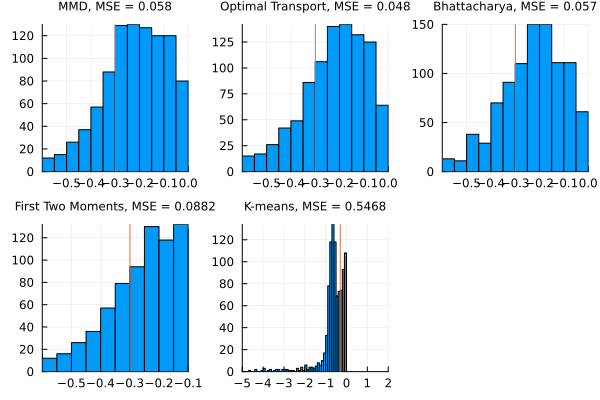

In [11]:
p1 = histogram(p_mmd, label = false, xlim = (-0.6,0));plot!([val],linetype=:vline,widths=3, labels = false);title!("MMD, MSE = $mmd_mse", titlefontsize=8)
p2 = histogram(p_opt, label = false,xlim = (-0.6,0));plot!([val],linetype=:vline,widths=3,labels = false);title!("Optimal Transport, MSE = $opt_mse",titlefontsize=8)
p3 = histogram(p_bhatt, label = false,xlim = (-0.6,0));plot!([val],linetype=:vline,widths=3,labels = false);title!("Bhattacharya, MSE = $bhatt_mse",titlefontsize=8)
p4 = histogram(p_kmeans, label = false,xlim = (-5,2));plot!([val],linetype=:vline,widths=3,labels = false);title!("K-means, MSE = $kmean_mse",titlefontsize=8)
p5 = histogram(p_moment, label = false,xlim = (-0.6,-0.1));plot!([val],linetype=:vline,widths=3,labels = false);title!("First Two Moments, MSE = $moment_mse",titlefontsize=8)
#plot(p1,p2,p3)
plot(p1,p2,p3,p5,p4)


In [12]:
savefig("./Figure/mse_summary.svg")

"/Users/yujingl3/Desktop/U1/Figure/mse_summary.svg"